In [31]:
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Get database credentials from environment
db_user = os.getenv("DB_USER", "postgres")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME", "ecommerce")

# Connect to database using SQLAlchemy
engine = create_engine(
    f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

# Test query
df = pd.read_sql("SELECT * FROM customers LIMIT 5", engine)
df

,customer_id,customer_age,customer_gender,region
0,C17270,60,Female,West
1,C17603,37,Male,South
2,C10860,34,Male,North
3,C15390,21,Female,South
4,C15226,39,Male,East


## Revenue Analysis

### Question 1: What are the top 10 products by total revenue?

In [51]:
# Query 1: What are the top 10 products by total revenue?
query1 = """
SELECT 
    p.product_name,
    p.category,
    SUM(oi.total_amount) AS product_total_revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_name, p.category
ORDER BY product_total_revenue DESC
LIMIT 10;
"""

df1 = pd.read_sql(query1, engine)
print(df1)

                          product_name     category  product_total_revenue
0      Max Smartwatch Platinum Edition  Electronics               41809.57
1         Pro Speaker Platinum Edition  Electronics               37594.19
2  Digital Smartwatch Platinum Edition  Electronics               30501.44
3       Ultra Speaker Platinum Edition  Electronics               29479.99
4       Digital Phone Platinum Edition  Electronics               29123.23
5      Digital Camera Platinum Edition  Electronics               28803.15
6      Elite Keyboard Platinum Edition  Electronics               27398.24
7     Premium Monitor Platinum Edition  Electronics               26900.39
8          Max Laptop Platinum Edition  Electronics               26707.01
9    Elite Smartwatch Platinum Edition  Electronics               26468.59


*Quick analysis*: The top 10 products by revenue are all in the Electronics category. Highly likely that Electronics is our leading category.

*Next steps*: If required, investigate other categories top selling products.

### Question 2: What is the monthly revenue trend with month-over-month growth percentage?

   month_year  monthly_total  prev_month  mom_growth_pct
0     2023-09      151135.60         NaN             NaN
1     2023-10      262502.74   151135.60           73.69
2     2023-11      240286.91   262502.74           -8.46
3     2023-12      255617.03   240286.91            6.38
4     2024-01      217766.09   255617.03          -14.81
5     2024-02      228013.98   217766.09            4.71
6     2024-03      248176.28   228013.98            8.84
7     2024-04      265596.66   248176.28            7.02
8     2024-05      264875.23   265596.66           -0.27
9     2024-06      234155.38   264875.23          -11.60
10    2024-07      253369.40   234155.38            8.21
11    2024-08      212613.20   253369.40          -16.09
12    2024-09      218873.90   212613.20            2.94
13    2024-10      258931.27   218873.90           18.30
14    2024-11      250572.04   258931.27           -3.23
15    2024-12      278154.19   250572.04           11.01
16    2025-01      224390.21   

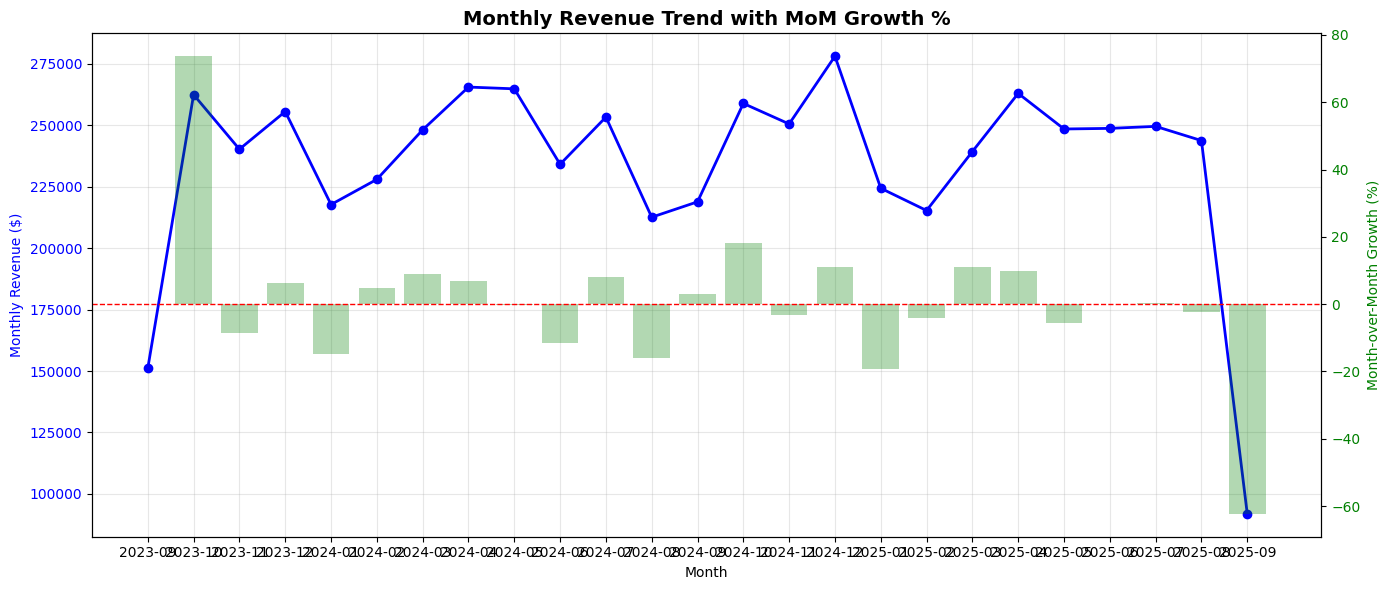

In [33]:
# Query 2: What is the monthly revenue trend with month-over-month growth percentage?
query2 = """
WITH monthly_revenue AS (
    SELECT 
        TO_CHAR(order_date, 'YYYY-MM') AS month_year,
        SUM(total_amount) AS monthly_total
    FROM order_items
    JOIN orders USING (order_id)
    GROUP BY month_year
)
SELECT 
    month_year,
    monthly_total,
    LAG(monthly_total) OVER (ORDER BY month_year) AS prev_month,
    ROUND(
        ((monthly_total - LAG(monthly_total) OVER (ORDER BY month_year)) 
         / LAG(monthly_total) OVER (ORDER BY month_year) * 100), 
        2
    ) as mom_growth_pct
FROM monthly_revenue
ORDER BY month_year;
"""

df2 = pd.read_sql(query2, engine)
print(df2)

# Visualization - Line Chart with Two Y-Axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Revenue line
ax1.plot(
    df2["month_year"],
    df2["monthly_total"],
    color="blue",
    marker="o",
    linewidth=2,
    label="Monthly Revenue",
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Monthly Revenue ($)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True, alpha=0.3)

# Growth percentage on second y-axis
ax2 = ax1.twinx()
ax2.bar(
    df2["month_year"],
    df2["mom_growth_pct"],
    alpha=0.3,
    color="green",
    label="MoM Growth %",
)
ax2.set_ylabel("Month-over-Month Growth (%)", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.axhline(y=0, color="red", linestyle="--", linewidth=1)

plt.title("Monthly Revenue Trend with MoM Growth %", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Quick analysis*: The first and final months may have incomplete financial data as they have significantly lower revenue than all the other months. MoM growth fluctuates between -20% and 20% with no observable pattern, however has had stable revenue in the past few months (again disregarding final month). Company's revenue is ebbing and flowing.

*Next steps*: would be to investigate first and final months to ensure data is incomplete, otherwise there are serious issues.

### Question 3: What percentage of total revenue does each category contribute?

      category  category_revenue  pct_of_total
0  Electronics        2652219.12         45.22
1         Home        1050472.85         17.91
2       Sports         661734.76         11.28
3      Fashion         638123.80         10.88
4       Beauty         320340.77          5.46
5         Toys         293538.25          5.00
6      Grocery         248863.50          4.24


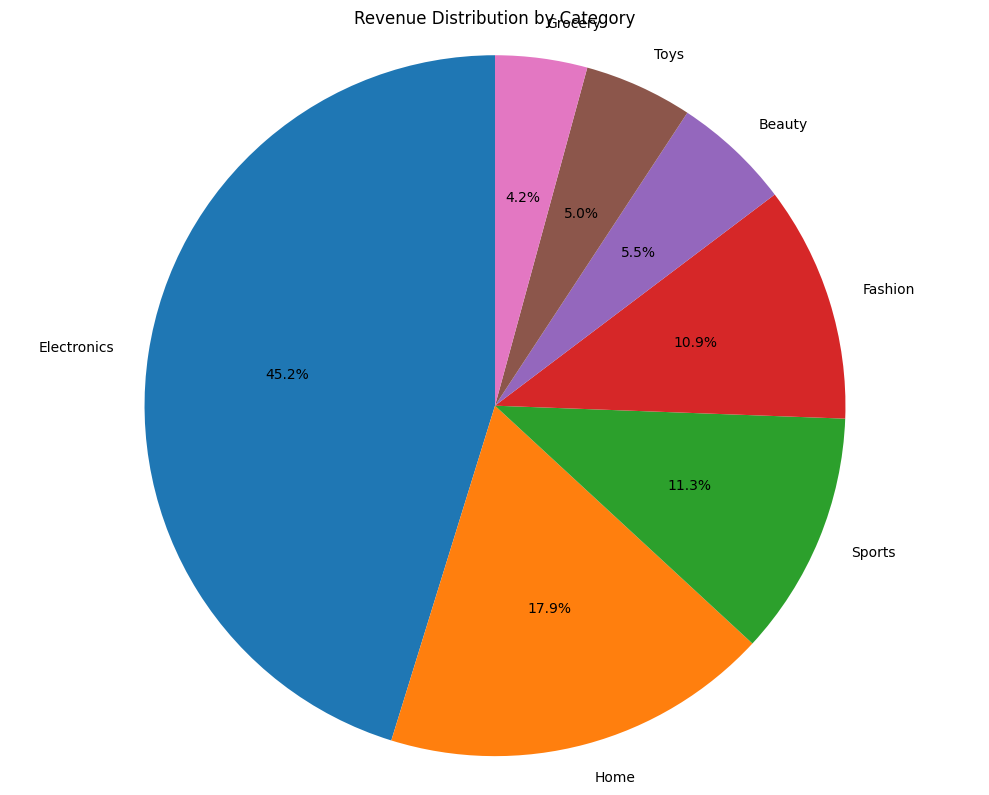

In [34]:
# Query 3: What percentage of total revenue does each category contribute?
query3 = """
SELECT 
    category,
    SUM(total_amount) as category_revenue,
    ROUND(100.0 * SUM(total_amount) / SUM(SUM(total_amount)) OVER (), 2) as pct_of_total
FROM order_items
JOIN products USING (product_id)
GROUP BY category
ORDER BY category_revenue DESC;
"""

df3 = pd.read_sql(query3, engine)
print(df3)

# Visualization - Pie Chart
plt.figure(figsize=(10, 8))
plt.pie(
    df3["category_revenue"], labels=df3["category"], autopct="%1.1f%%", startangle=90
)
plt.title("Revenue Distribution by Category")
plt.axis("equal")
plt.tight_layout()
plt.show()

*Quick analysis*: Electronics is definitely the leading category, accounting for nearly half of all revenue. Grocery, Toys and Beauty are the lwoest, all around 5%.

*Next steps*: If company is looking to diversify it's revenue stream, bundling Electronic products with poorer performing categories could boost sales + product use in those categories.

### Question 4: Which are the top 3 products in each category by revenue?

In [52]:
# Query 4: Which are the top 3 products in each category by revenue?
query4 = """
SELECT 
    category,
    product_name,
    revenue,
    rank
FROM (
    SELECT 
        p.category,
        p.product_name,
        SUM(oi.total_amount) as revenue,
        RANK() OVER (PARTITION BY p.category ORDER BY SUM(oi.total_amount) DESC) as rank
    FROM order_items oi
    JOIN products p USING (product_id)
    GROUP BY p.category, p.product_name
) ranked
WHERE rank <= 3
ORDER BY category, rank;
"""

df4 = pd.read_sql(query4, engine)
print(df4)

       category                         product_name   revenue  rank
0        Beauty                       Luxury Shampoo  17608.85     1
1        Beauty                           Pure Serum   9461.03     2
2        Beauty                        Natural Serum   8736.62     3
3   Electronics      Max Smartwatch Platinum Edition  41809.57     1
4   Electronics         Pro Speaker Platinum Edition  37594.19     2
5   Electronics  Digital Smartwatch Platinum Edition  30501.44     3
6       Fashion                          Trendy Belt  12685.84     1
7       Fashion                         Modern Watch  12294.05     2
8       Fashion                        Classic Jeans  11954.53     3
9       Grocery                          Natural Tea   8328.29     1
10      Grocery                        Wholesome Tea   8006.47     2
11      Grocery                         Premium Rice   6935.28     3
12         Home          Comfort Pillow Gold Edition  13419.02     1
13         Home          Premium P

*Quick analysis*: Beauty, Sports and Toys (2 of the 3 lowest performing categories) have one 'hero' product that is leading sales by some distance. Other categories have smaller distances between the top 3 products.

*Next steps*: For Beauty and Toys, bundling other products (or even new similar products) with the 'hero' product can boost sales long-term, as customers begin to use other items.

### Question 5: What is the running total of revenue over time?

                        date  daily_revenue  running_total
0  2023-09-12 00:00:00+10:00        6727.75        6727.75
1  2023-09-13 00:00:00+10:00        9678.11       16405.86
2  2023-09-14 00:00:00+10:00        5622.59       22028.45
3  2023-09-15 00:00:00+10:00        5531.77       27560.22
4  2023-09-16 00:00:00+10:00       10853.21       38413.43
5  2023-09-17 00:00:00+10:00        7623.81       46037.24
6  2023-09-18 00:00:00+10:00       11508.24       57545.48
7  2023-09-19 00:00:00+10:00        7222.19       64767.67
8  2023-09-20 00:00:00+10:00        6188.30       70955.97
9  2023-09-21 00:00:00+10:00        4386.89       75342.86
                          date  daily_revenue  running_total
729  2025-09-10 00:00:00+10:00        9878.84     5859230.44
730  2025-09-11 00:00:00+10:00        6062.61     5865293.05


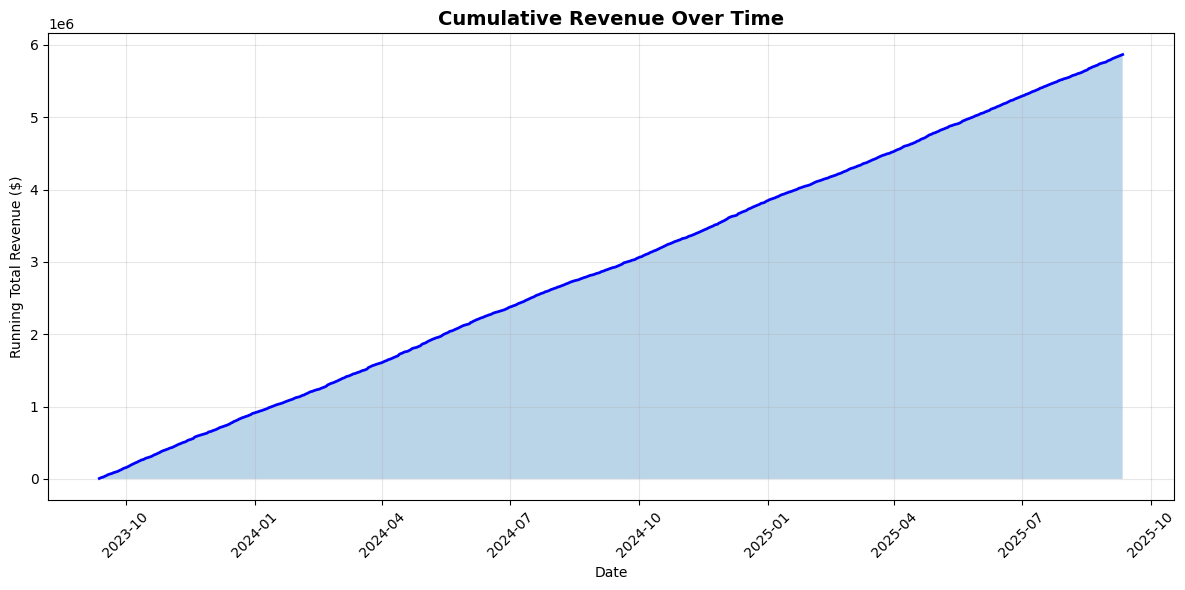

In [36]:
# Query 5: What is the running total of revenue over time?
query5 = """
SELECT 
    DATE_TRUNC('day', order_date) as date,
    SUM(total_amount) as daily_revenue,
    SUM(SUM(total_amount)) OVER (ORDER BY DATE_TRUNC('day', order_date) 
                                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as running_total
FROM orders
JOIN order_items USING (order_id)
GROUP BY DATE_TRUNC('day', order_date)
ORDER BY date;
"""

df5 = pd.read_sql(query5, engine)
print(df5.head(10))  # Show first 10 days
print(df5.tail(2))  # Show last 2 days

# Visualization - Line Chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df5["date"], df5["running_total"], linewidth=2, color="blue")
ax.fill_between(df5["date"], df5["running_total"], alpha=0.3)
ax.set_title("Cumulative Revenue Over Time", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Running Total Revenue ($)")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Quick analysis*: Steady income over time, no periods of serious plateau.

*Next steps*: No real next steps, continue to monitor in case of changes.

### Revenue Analysis Summary

*Key Findings:*

Product Mix: Electronics dominates completely—comprises all top-10 revenue products and ~50% of total revenue

Growth Pattern: Month-over-month revenue fluctuates (-20% to +20%) with no clear pattern, but shows stability in recent months (excluding potentially incomplete first/final months)

Category Imbalance: Wide disparity exists—Grocery, Toys, and Beauty each represent only ~5% of revenue

Category Leaders: Beauty, Sports, and Toys have single 'hero' products significantly outselling the rest; other categories show more balanced revenue distribution

Revenue Trajectory: Consistent daily growth over time with no extended plateaus or major stalls

**Business Implication:** Electronics is a cash cow, but the business is heavily dependent on one category. Revenue is stable but growth is inconsistent. There's untapped potential in bundling weak categories with hero products to diversify revenue streams.

### Question 1: Who are the top 10 customers by lifetime value?

       customer_name   region  customer_age customer_gender  lifetime_value
0         Cathy Holt  Central            48          Female        13885.10
1     Diana Williams    South            32          Female        11984.28
2       John Hawkins     West            42            Male        11375.58
3    Gregory Wheeler     West            26            Male         7424.34
4        Dana Graham    North            51          Female         7244.07
5     Jocelyn Wilson    South            30          Female         7209.12
6      Darren Burton  Central            58            Male         6973.06
7        Ricky Silva     East            68            Male         6546.60
8       Brett Oliver  Central            28            Male         6509.95
9  Wayne Christensen    South            55            Male         6480.16


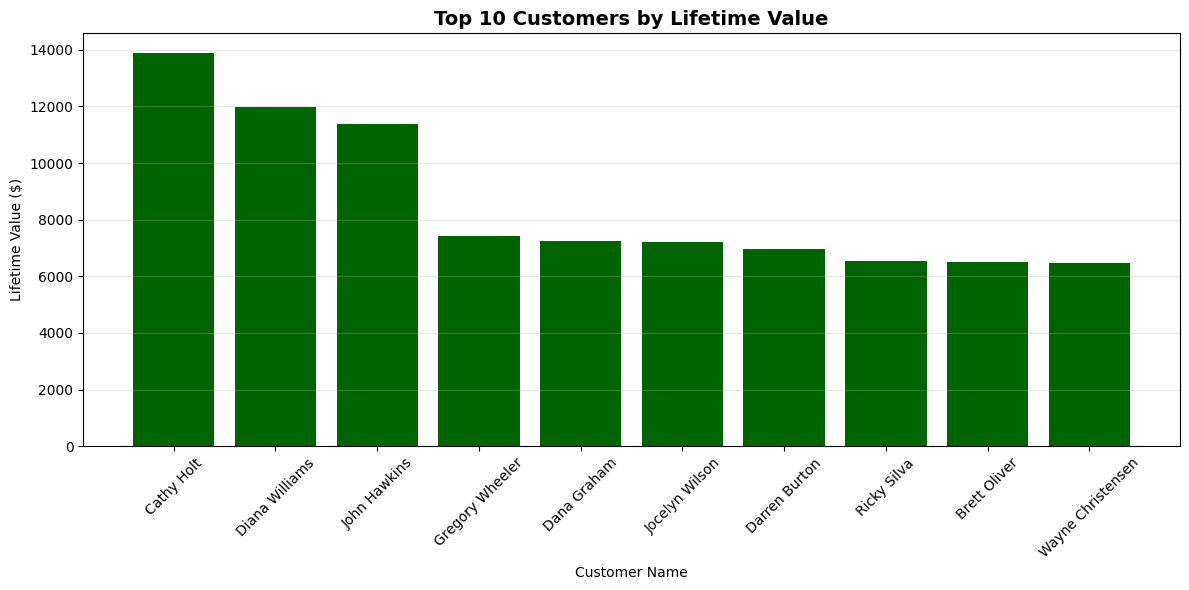

In [54]:
# Query 6: Who are the top 10 customers by lifetime value?
query6 = """
SELECT 
    c.customer_name,
    c.region,
    c.customer_age,
    c.customer_gender,
    SUM(oi.total_amount) AS lifetime_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_name, c.region, c.customer_age, c.customer_gender
ORDER BY lifetime_value DESC
LIMIT 10;
"""

df6 = pd.read_sql(query6, engine)
print(df6)

# Visualization - Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(df6["customer_name"].astype(str), df6["lifetime_value"], color="darkgreen")
plt.title("Top 10 Customers by Lifetime Value", fontsize=14, fontweight="bold")
plt.xlabel("Customer Name")
plt.ylabel("Lifetime Value ($)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Question 2: What is the customer retention rate (customers who made repeat purchases)?

*Quick analysis*: 3 customers are well and truly ahead of everyone else.

*Next steps*: If important, could examine if it is number of purchases, or average price of purchase, that is driving customers to the top.

In [38]:
# Query 7: What is the customer retention rate (customers who made repeat purchases)?
query7 = """
WITH customer_orders AS (
    SELECT 
        customer_id,
        COUNT(DISTINCT order_id) AS order_count
    FROM orders
    GROUP BY customer_id
)
SELECT 
    COUNT(CASE WHEN order_count > 1 THEN 1 END) AS repeat_customers,
    COUNT(*) AS total_customers,
    ROUND(100.0 * COUNT(CASE WHEN order_count > 1 THEN 1 END) / COUNT(*), 2) AS retention_rate_pct
FROM customer_orders;
"""

df7 = pd.read_sql(query7, engine)
print(df7)

# Display result
print(f"\nCustomer Retention Rate: {df7['retention_rate_pct'][0]}%")
print(
    f"Repeat Customers: {df7['repeat_customers'][0]} out of {df7['total_customers'][0]}"
)

   repeat_customers  total_customers  retention_rate_pct
0              7428             7903               93.99

Customer Retention Rate: 93.99%
Repeat Customers: 7428 out of 7903


### Question 3: Divide customers into 5 spending groups to facilitate advertising campaigns

*Quick analysis*: Very high retention rate, with only 6% of customers being single purchase customers.

*Next steps*: Identify these customers and promote our current options. Identify our churn rate for each quarter (along with our new customers). Theroetically, if a customer made 2 purchases 2 years apart, they aren't counted as churning. Narrow down for business needs.

           customer_name   region  customer_age customer_gender  total_spent  \
0             Cathy Holt  Central            48          Female     13885.10   
1         Diana Williams    South            32          Female     11984.28   
2           John Hawkins     West            42            Male     11375.58   
3        Gregory Wheeler     West            26            Male      7424.34   
4            Dana Graham    North            51          Female      7244.07   
5         Jocelyn Wilson    South            30          Female      7209.12   
6          Darren Burton  Central            58            Male      6973.06   
7            Ricky Silva     East            68            Male      6546.60   
8           Brett Oliver  Central            28            Male      6509.95   
9      Wayne Christensen    South            55            Male      6480.16   
10        Marcus Jackson    South            48            Male      6479.25   
11           David Smith     East       

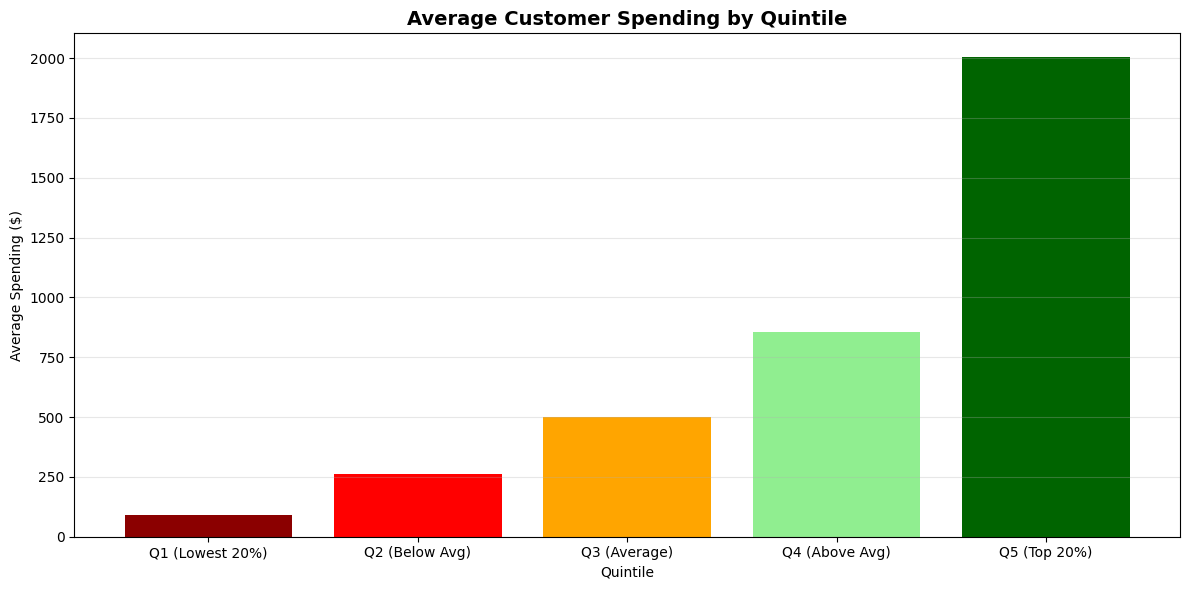

           customer_name   region  customer_age customer_gender  total_spent  \
0             Cathy Holt  Central            48          Female     13885.10   
1         Diana Williams    South            32          Female     11984.28   
2           John Hawkins     West            42            Male     11375.58   
3        Gregory Wheeler     West            26            Male      7424.34   
4            Dana Graham    North            51          Female      7244.07   
5         Jocelyn Wilson    South            30          Female      7209.12   
6          Darren Burton  Central            58            Male      6973.06   
7            Ricky Silva     East            68            Male      6546.60   
8           Brett Oliver  Central            28            Male      6509.95   
9      Wayne Christensen    South            55            Male      6480.16   
10        Marcus Jackson    South            48            Male      6479.25   
11           David Smith     East       

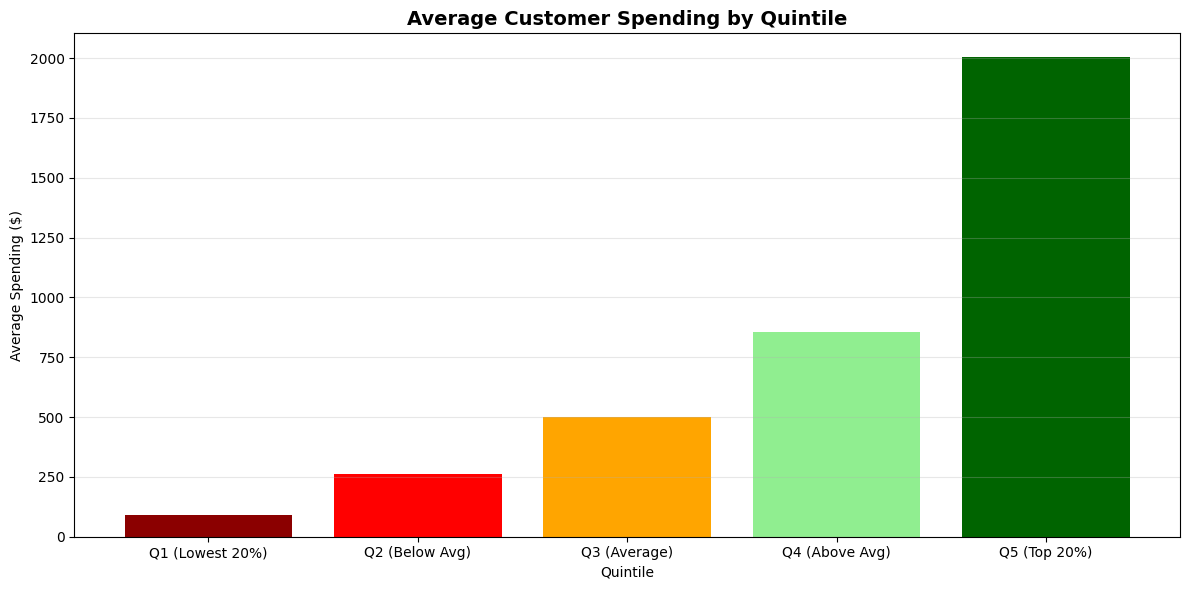


Quintile Distribution by Region:
region           Central  East  North  South  West
quintile_label                                    
Q1 (Lowest 20%)      272   313    331    339   326
Q2 (Below Avg)       254   317    336    354   319
Q3 (Average)         255   321    325    349   330
Q4 (Above Avg)       261   309    363    326   321
Q5 (Top 20%)         268   317    345    355   295

Quintile Distribution by Gender:
customer_gender  Female  Male  Other
quintile_label                      
Q1 (Lowest 20%)     769   740     72
Q2 (Below Avg)      782   745     53
Q3 (Average)        762   755     63
Q4 (Above Avg)      767   748     65
Q5 (Top 20%)        770   756     54


In [55]:
# Query 8: Divide customers into spending quintiles (5 groups)
from sqlalchemy import text

query8 = text(
    """
WITH customer_spending AS (
    SELECT 
        c.customer_name,
        c.region,
        c.customer_age,
        c.customer_gender,
        SUM(oi.total_amount) AS total_spent
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_name, c.region, c.customer_age, c.customer_gender
)
SELECT 
    customer_name,
    region,
    customer_age,
    customer_gender,
    total_spent,
    NTILE(5) OVER (ORDER BY total_spent) AS spending_quintile,
    CASE 
        WHEN NTILE(5) OVER (ORDER BY total_spent) = 1 THEN 'Q1 (Lowest 20%)'
        WHEN NTILE(5) OVER (ORDER BY total_spent) = 2 THEN 'Q2 (Below Avg)'
        WHEN NTILE(5) OVER (ORDER BY total_spent) = 3 THEN 'Q3 (Average)'
        WHEN NTILE(5) OVER (ORDER BY total_spent) = 4 THEN 'Q4 (Above Avg)'
        WHEN NTILE(5) OVER (ORDER BY total_spent) = 5 THEN 'Q5 (Top 20%)'
    END AS quintile_label
FROM customer_spending
ORDER BY total_spent DESC;
"""
)

df8 = pd.read_sql(query8, engine)
print(df8.head(20))

# Summary by Quintile
quintile_summary = (
    df8.groupby("quintile_label")
    .agg({"customer_name": "count", "total_spent": ["min", "max", "mean", "sum"]})
    .round(2)
)
print("\nQuintile Summary:")
print(quintile_summary)

# Visualization - Bar Chart of Average Spending per Quintile
avg_by_quintile = df8.groupby("quintile_label")["total_spent"].mean().sort_values()
plt.figure(figsize=(12, 6))
colors = ["darkred", "red", "orange", "lightgreen", "darkgreen"]
plt.bar(avg_by_quintile.index, avg_by_quintile.values, color=colors)
plt.title("Average Customer Spending by Quintile", fontsize=14, fontweight="bold")
plt.xlabel("Quintile")
plt.ylabel("Average Spending ($)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Demographics Analysis
print("\nQuintile Distribution by Region:")
print(pd.crosstab(df8["quintile_label"], df8["region"]))

print("\nQuintile Distribution by Gender:")
print(pd.crosstab(df8["quintile_label"], df8["customer_gender"]))

### Question 4: What is the average order value by customer age group?

*Quick analysis*: Expected differences between the 5 groups, towards an exponential growth as we get from the lowest to the largest. No discernible trends in Gender and Region distribution.

*Next steps*: Send promotions to lower 20%, send rewards to Q3 + Q4 to encourage further spending (as Q5 likely doesn't need any further incentive to spend).

  age_group  num_orders  avg_order_value
0     18-25        5369           171.78
1     26-35        6472           172.19
2     36-45        6618           165.24
3     46-55        6434           175.09
4     56-70        9607           167.44


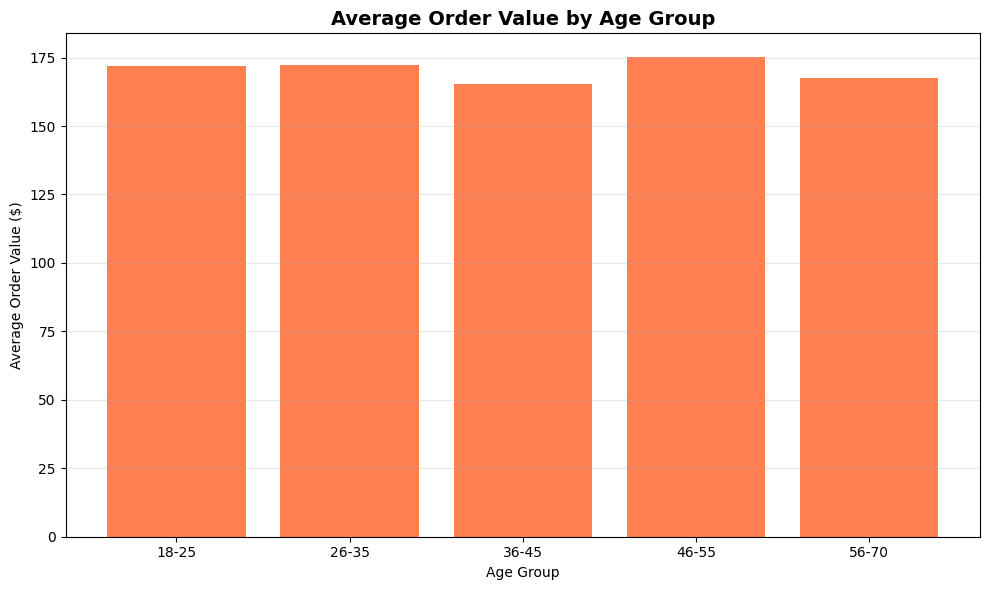

In [40]:
# Query 9: What is the average order value by customer age group?
query9 = """
SELECT 
    CASE 
        WHEN customer_age BETWEEN 18 AND 25 THEN '18-25'
        WHEN customer_age BETWEEN 26 AND 35 THEN '26-35'
        WHEN customer_age BETWEEN 36 AND 45 THEN '36-45'
        WHEN customer_age BETWEEN 46 AND 55 THEN '46-55'
        WHEN customer_age BETWEEN 56 AND 70 THEN '56-70'
        ELSE 'Other'
    END AS age_group,
    COUNT(DISTINCT o.order_id) AS num_orders,
    ROUND(AVG(oi.total_amount), 2) AS avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY age_group
ORDER BY age_group;
"""

df9 = pd.read_sql(query9, engine)
print(df9)

# Visualization - Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(df9["age_group"], df9["avg_order_value"], color="coral")
plt.title("Average Order Value by Age Group", fontsize=14, fontweight="bold")
plt.xlabel("Age Group")
plt.ylabel("Average Order Value ($)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Question 5: Which regions have the highest customer lifetime value?

*Quick analysis*: No discernible trend of order value by age.

*Next steps*: No actions from this analysis.

    region  num_customers  total_revenue  avg_ltv_per_customer
0    South           1725     1298699.62                752.87
1    North           1700     1265920.58                744.66
2     East           1577     1168045.16                740.68
3     West           1591     1157959.85                727.82
4  Central           1310      974667.84                744.02


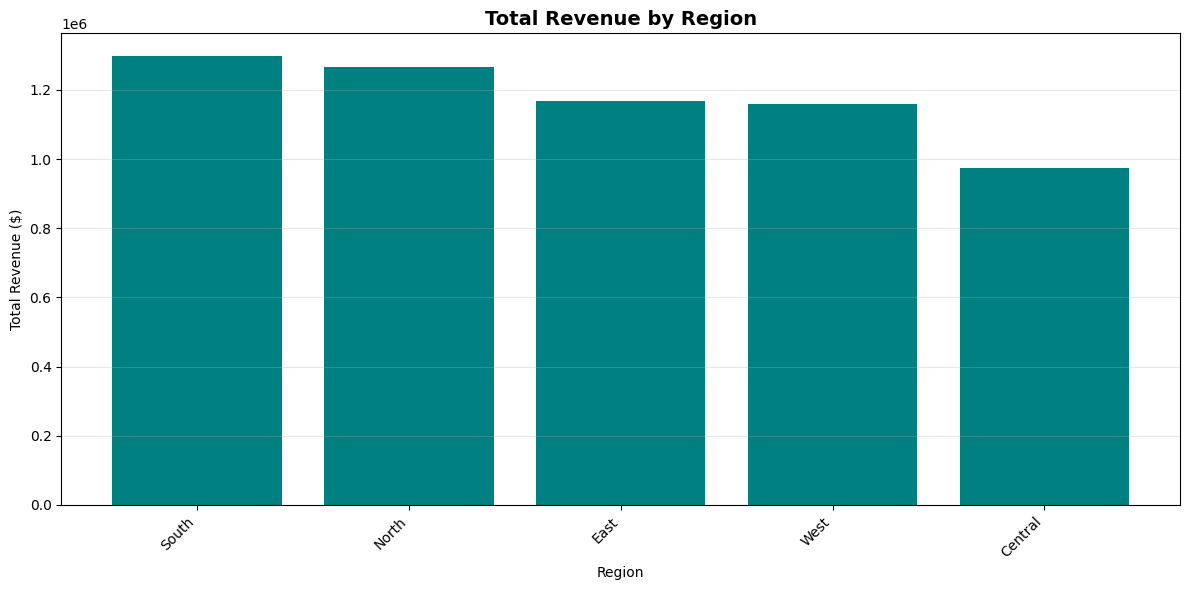

In [41]:
# Query 10: Which regions have the highest customer lifetime value?
query10 = """
SELECT 
    c.region,
    COUNT(DISTINCT c.customer_id) AS num_customers,
    SUM(oi.total_amount) AS total_revenue,
    ROUND(SUM(oi.total_amount) / COUNT(DISTINCT c.customer_id), 2) AS avg_ltv_per_customer
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.region
ORDER BY total_revenue DESC;
"""

df10 = pd.read_sql(query10, engine)
print(df10)

# Visualization - Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(df10["region"], df10["total_revenue"], color="teal")
plt.title("Total Revenue by Region", fontsize=14, fontweight="bold")
plt.xlabel("Region")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Question 6: What is the distribution of customers by gender and their average spending?

*Quick analysis*: South and North regions are the most profitable per person, with East and West cose behind and Central lagging.

*Next steps*: Incentivise existing customers in Central via promotions/deals (to increase sales per customer, and thus lifetime value), advertising campaigns for awareness in the other four regions (to incentivise more people to shop with us, as they will likely spend more once they join)

  customer_gender  num_customers  avg_spending  total_revenue
0          Female           3852        169.89     2842216.04
1            Male           3744        170.94     2805855.38
2           Other            307        160.19      217221.63


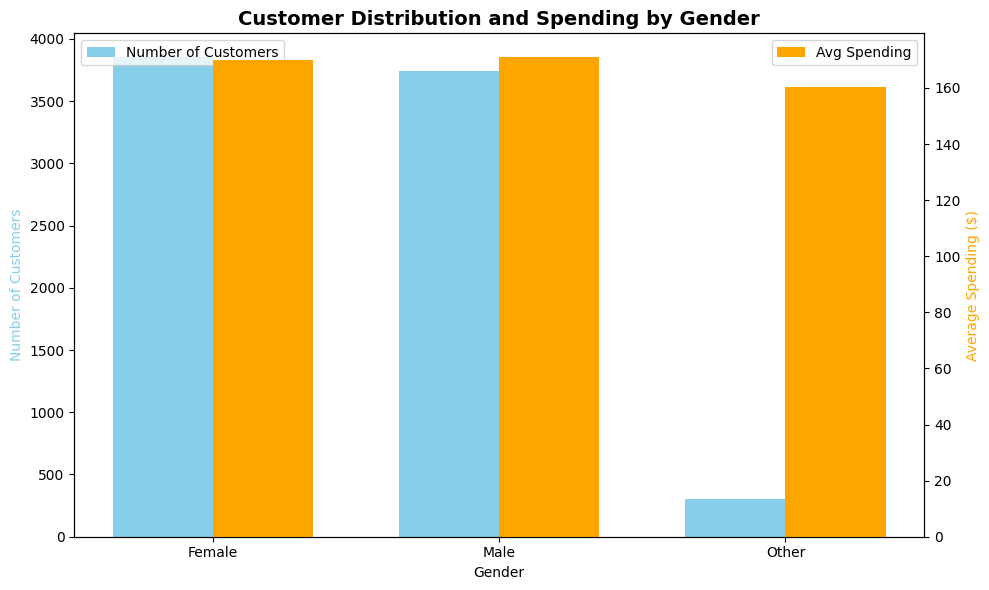

In [42]:
# Query 11: What is the distribution of customers by gender and their average spending?
query11 = """
SELECT 
    c.customer_gender,
    COUNT(DISTINCT c.customer_id) AS num_customers,
    ROUND(AVG(oi.total_amount), 2) AS avg_spending,
    SUM(oi.total_amount) AS total_revenue
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_gender
ORDER BY total_revenue DESC;
"""

df11 = pd.read_sql(query11, engine)
print(df11)

# Visualization - Grouped Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df11))
width = 0.35

ax.bar(
    [i - width / 2 for i in x],
    df11["num_customers"],
    width,
    label="Number of Customers",
    color="skyblue",
)
ax2 = ax.twinx()
ax2.bar(
    [i + width / 2 for i in x],
    df11["avg_spending"],
    width,
    label="Avg Spending",
    color="orange",
)

ax.set_xlabel("Gender")
ax.set_ylabel("Number of Customers", color="skyblue")
ax2.set_ylabel("Average Spending ($)", color="orange")
ax.set_xticks(x)
ax.set_xticklabels(df11["customer_gender"])
ax.set_title(
    "Customer Distribution and Spending by Gender", fontsize=14, fontweight="bold"
)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Question 7: What is the purchase sequence for each customer (numbered chronologically)?

*Quick analysis*: Slightly more females than males, and a noticeable drop-off for other, which is entirely expected. Slgiht dip in average spend for the 'Other' category, but nothing alarming.

*Next steps*: No desperate action required.

       customer_name order_id  order_date  total_amount  purchase_number  \
0       Aaron Austin  O127153  2024-03-24          5.48                1   
1       Aaron Austin  O109953  2025-08-18        214.99                2   
2      Aaron Ballard  O132301  2024-06-01         25.25                1   
3      Aaron Ballard  O132085  2024-08-10          7.56                2   
4      Aaron Ballard  O121111  2025-02-02         18.71                3   
5      Aaron Ballard  O110536  2025-07-23          1.24                4   
6        Aaron Boyer  O120042  2023-12-25        122.17                1   
7        Aaron Boyer  O112850  2025-06-16         29.43                2   
8        Aaron Brock  O118278  2024-02-17         19.86                1   
9        Aaron Brock  O129841  2024-08-30         30.87                2   
10       Aaron Brock  O133582  2024-09-22         83.35                3   
11    Aaron Clements  O120026  2024-04-07         54.81                1   
12    Aaron 

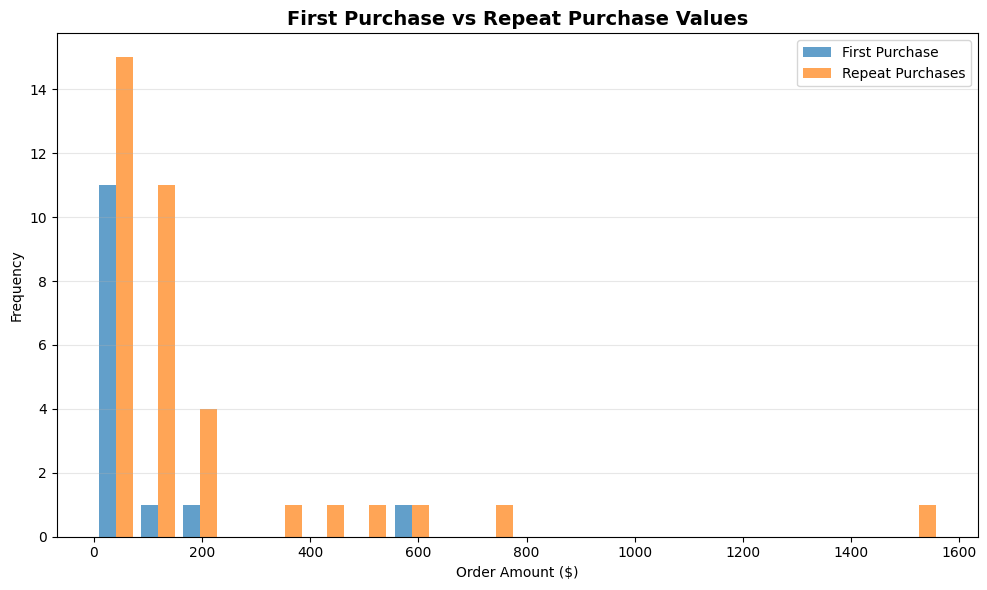


Average First Purchase: $84.90
Average Repeat Purchase: $184.53


In [57]:
# Query 12: What is the purchase sequence for each customer (numbered chronologically)?
query12 = """
SELECT 
    c.customer_name,
    o.order_id,
    o.order_date,
    oi.total_amount,
    ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY o.order_date) AS purchase_number,
    SUM(oi.total_amount) OVER (
        PARTITION BY o.customer_id 
        ORDER BY o.order_date 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS cumulative_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
ORDER BY c.customer_name, purchase_number;
"""

df12 = pd.read_sql(query12, engine)
print(df12.head(20))

# First vs Repeat Purchase Value
first_purchases = df12[df12["purchase_number"] == 1]["total_amount"]
repeat_purchases = df12[df12["purchase_number"] > 1]["total_amount"]

# Summary Stats
print(f"\nAverage First Purchase: ${first_purchases.mean():.2f}")
print(f"Average Repeat Purchase: ${repeat_purchases.mean():.2f}")
print(f"Sum First Purchase: ${first_purchases.sum():.2f}")
print(f"Sum Repeat Purchase: ${repeat_purchases.sum():.2f}")

*Quick Analysis*: The average first purchase is actually higher than the average repeat purchases, but revenue is much higher on repeat purchases. If we can get people coming back to the store (reduce churn rate), we will make more money.
 
*Next Steps*: Check if time between purchases is a factor in how much a person spends.

### Customer Analysis Summary

*Key Findings:*

High-Value Concentration: Three customers significantly outspend all others—investigate whether driven by purchase frequency or order value

Excellent Retention: 94% of customers make repeat purchases; only 6% are single-purchase customers

Spending Distribution: Customer spending follows expected exponential progression across quintiles with no gender or regional clustering patterns

Age Neutrality: No discernible trend in average order value by age group; age is not a purchase driver

Gender Balance: Slightly more female customers than male; negligible spending difference by gender; "Other" category present but minimal

**Business Implication:** Strong retention indicates product-market fit, but concentrated high-value customers create revenue risk. Regional disparities suggest opportunities for Central region growth through targeted promotions. Age-agnostic spending supports unified marketing approach rather than age-segmentation.

## Product & Operations

### Question 1: Which products have the highest return rate?

In [67]:
# Query 13: Which products have the highest return rate?
query13 = """
SELECT 
    p.product_name,
    p.category,
    COUNT(*) AS total_items_sold,
    COUNT(CASE WHEN oi.returned = 'Yes' THEN 1 END) AS items_returned,
    ROUND(100.0 * COUNT(CASE WHEN oi.returned = 'Yes' THEN 1 END) / COUNT(*), 2) AS return_rate_pct
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_name, p.category
HAVING COUNT(*) >= 10  -- Only products with at least 10 sales
ORDER BY return_rate_pct DESC
LIMIT 15;
"""

df13 = pd.read_sql(query13, engine)
print(df13)

                           product_name     category  total_items_sold  \
0         Training Weights Gold Edition       Sports                10   
1                       Premium Speaker  Electronics                10   
2           Trendy Jeans Silver Edition      Fashion                14   
3           Max Camera Platinum Edition  Electronics                21   
4                    Premium Smartwatch  Electronics                14   
5          Digital Phone Silver Edition  Electronics                24   
6     Classic Sunglasses Silver Edition      Fashion                13   
7   Premium Headphones Platinum Edition  Electronics                19   
8           Trendy Dress Silver Edition      Fashion                10   
9          Elegant Shirt Silver Edition      Fashion                10   
10  Premium Smartwatch Platinum Edition  Electronics                20   
11         Elegant Shoes Silver Edition      Fashion                10   
12          Modern Shirt Silver Editio

*Quick Analysis*: Certain products have very high return rates (20% is too high, let alone 30%), amongst products that sell at lest 10 products. Dominated by Fashion and Electronics, but Sports object is the worst.

*Next Steps*: Get customer feedback on products, and consider options to improve quality or remove from inventory.

### Question 2: What is the correlation between discount percentage and quantity sold?

  discount_range  avg_quantity  num_orders
0             0%        1.4946       18939
1          0-10%        1.4943       10335
2         10-20%        1.4695        4522
3         20-30%        1.4688         704


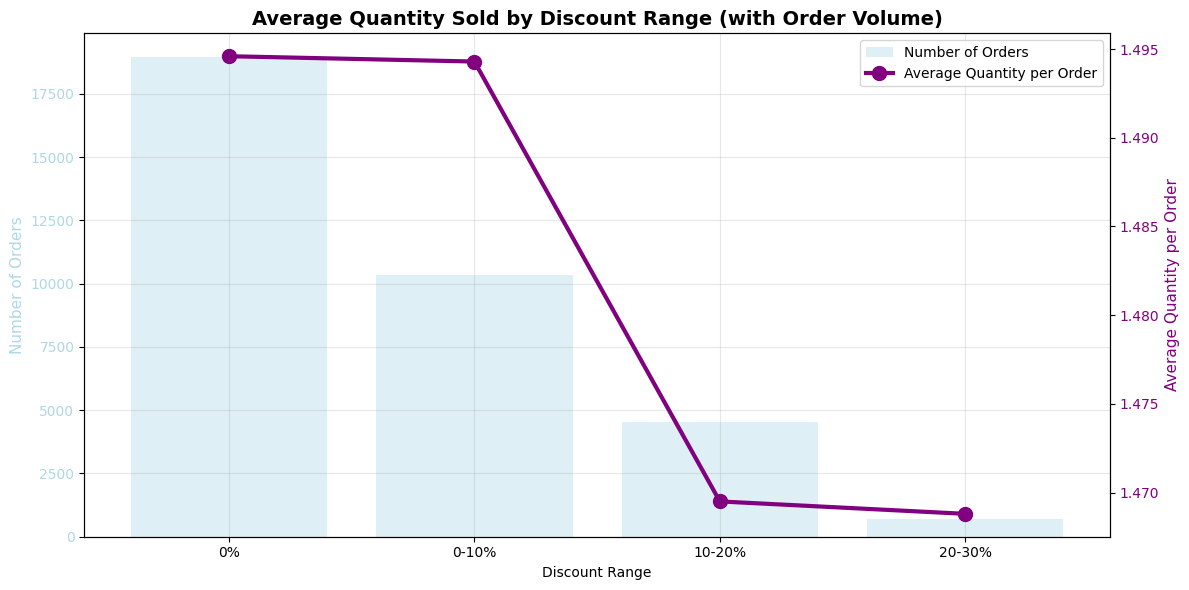

In [45]:
# Query 14: What is the correlation between discount percentage and quantity sold?
from sqlalchemy import text

query14 = text(
    """
WITH discount_categorized AS (
    SELECT 
        CASE 
            WHEN discount = 0 THEN '0%'
            WHEN discount > 0 AND discount <= 0.1 THEN '0-10%'
            WHEN discount > 0.1 AND discount <= 0.2 THEN '10-20%'
            WHEN discount > 0.2 AND discount <= 0.3 THEN '20-30%'
            ELSE '30%+'
        END AS discount_range,
        quantity
    FROM order_items
)
SELECT 
    discount_range,
    ROUND(AVG(quantity), 4) AS avg_quantity,
    COUNT(*) AS num_orders
FROM discount_categorized
GROUP BY discount_range
ORDER BY 
    CASE discount_range
        WHEN '0%' THEN 1
        WHEN '0-10%' THEN 2
        WHEN '10-20%' THEN 3
        WHEN '20-30%' THEN 4
        ELSE 5
    END;
"""
)

df14 = pd.read_sql(query14, engine)
print(df14)

# Visualization - Line Chart with Background Bar Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart in background - Order volume
ax1.bar(
    df14["discount_range"],
    df14["num_orders"],
    alpha=0.4,
    color="lightblue",
    label="Number of Orders",
)
ax1.set_ylabel("Number of Orders", color="lightblue", fontsize=11)
ax1.tick_params(axis="y", labelcolor="lightblue")

# Line chart in foreground - Average quantity
ax2 = ax1.twinx()
ax2.plot(
    df14["discount_range"],
    df14["avg_quantity"],
    marker="o",
    linewidth=3,
    markersize=10,
    color="purple",
    label="Average Quantity per Order",
    zorder=10,
)
ax2.set_ylabel("Average Quantity per Order", color="purple", fontsize=11)
ax2.tick_params(axis="y", labelcolor="purple")

ax1.set_xlabel("Discount Range")
ax1.set_title(
    "Average Quantity Sold by Discount Range (with Order Volume)",
    fontsize=14,
    fontweight="bold",
)
ax1.grid(True, alpha=0.3, zorder=0)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

*Quick Analysis*: Average quantity per order is influenced by discount rate in the opposite way expected (higher discount doesn't lead to more quantity). However, the difference is a matter of 0.03 per order, so it's not drastic by any means. The volume of orders per discount category is intuitive, as most of our products won't be dicoutned heavily, and thus the sales shouldn't be higher as the discounts go up.

*Next Steps*: Examine products to see if being discounted leads to more sales, and identify products that sell far more when on sale. Could give insights into pricing issues.

### Question 3: What is the average delivery time by region, ranked from fastest to slowest?

In [46]:
# Query 15: What is the average delivery time by region, ranked from fastest to slowest?
query15 = """
SELECT 
    c.region,
    COUNT(o.order_id) AS num_orders,
    ROUND(AVG(o.delivery_time_days), 2) AS avg_delivery_days,
    RANK() OVER (ORDER BY AVG(o.delivery_time_days)) AS delivery_rank
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.region
ORDER BY avg_delivery_days;
"""

df15 = pd.read_sql(query15, engine)
print(df15)

    region  num_orders  avg_delivery_days  delivery_rank
0    North        7510               4.62              1
1  Central        5703               4.64              2
2    South        7558               4.84              3
3     West        6997               4.87              4
4     East        6732               5.09              5


*Quick Analysis*: East has te worst delivery time, tipping over 5 days which represents a business week. Regions with more orders performed better, with North having nearly the most orders along with the best delivery time.

*Next Steps*: Examine delivery infrastructure in the East to ensure that average delivery time is reduced below 5, so that we can advertise our 'shipped to you in a week' truthfully.

### Question 4: Which payment methods are most popular by region?

     region payment_method  num_orders  pct_in_region
0   Central    Credit Card        2050          35.95
1   Central     Debit Card        1426          25.00
2   Central            UPI         661          11.59
3   Central            COD         649          11.38
4   Central         PayPal         574          10.06
5   Central         Wallet         343           6.01
6      East    Credit Card        2374          35.26
7      East     Debit Card        1634          24.27
8      East            COD         822          12.21
9      East            UPI         809          12.02
10     East         PayPal         671           9.97
11     East         Wallet         422           6.27
12    North    Credit Card        2613          34.79
13    North     Debit Card        1907          25.39
14    North            UPI         941          12.53
15    North            COD         846          11.26
16    North         PayPal         770          10.25
17    North         Wallet  

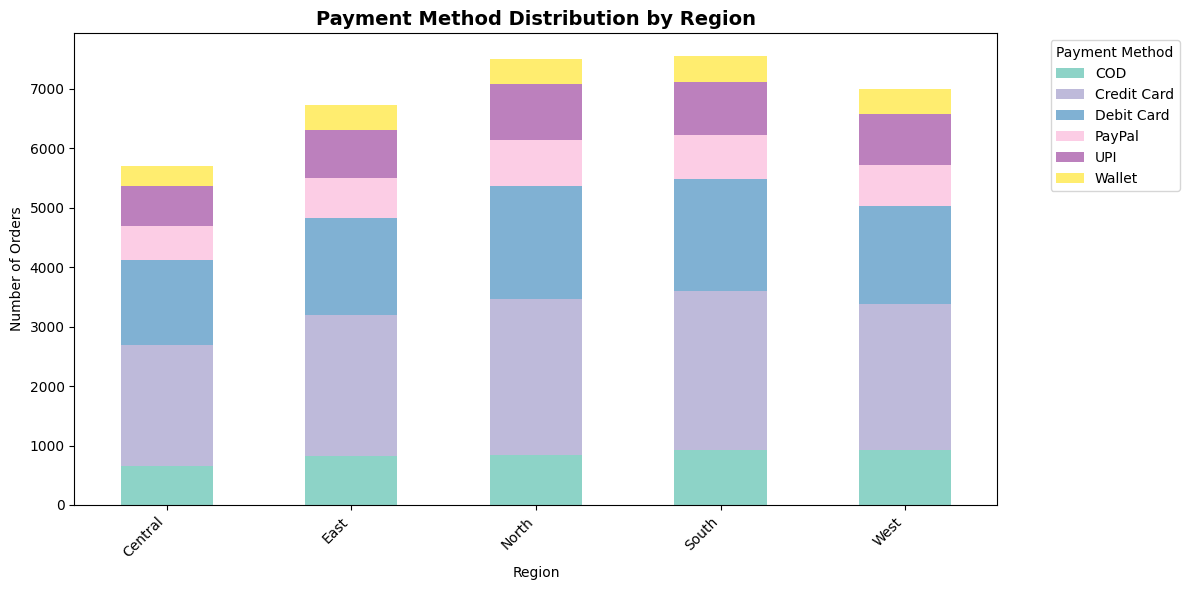

In [47]:
# Query 16: Which payment methods are most popular by region?
query16 = """
SELECT 
    c.region,
    o.payment_method,
    COUNT(*) AS num_orders,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY c.region), 2) AS pct_in_region
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.region, o.payment_method
ORDER BY c.region, num_orders DESC;
"""

df16 = pd.read_sql(query16, engine)
print(df16)

# Visualization - Stacked Bar Chart
pivot = df16.pivot(
    index="region", columns="payment_method", values="num_orders"
).fillna(0)
pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set3")
plt.title("Payment Method Distribution by Region", fontsize=14, fontweight="bold")
plt.xlabel("Region")
plt.ylabel("Number of Orders")
plt.legend(title="Payment Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

*Quick Analysis*: Credit card and debit card are the most popular across all regions. All regions have roughly the same distribution of payments methods

*Next Steps*: Examine costs of facilitating lower revenue-producing methods and make decision if we continue to facilitate.

### Question 5: What are the most profitable categories ranked by profit margin percentage?

In [48]:
# Query 17: What are the most profitable categories ranked by profit margin percentage?
query17 = """
SELECT 
    p.category,
    SUM(oi.total_amount) AS total_revenue,
    SUM(oi.profit_margin) AS total_profit,
    ROUND(100.0 * SUM(oi.profit_margin) / SUM(oi.total_amount), 2) AS profit_margin_pct,
    RANK() OVER (ORDER BY (100.0 * SUM(oi.profit_margin) / SUM(oi.total_amount)) DESC) AS profit_rank
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.category
ORDER BY profit_margin_pct DESC;
"""

df17 = pd.read_sql(query17, engine)
print(df17)

      category  total_revenue  total_profit  profit_margin_pct  profit_rank
0       Sports      661734.76     148247.70              22.40            1
1      Fashion      638123.80     142409.44              22.32            2
2         Home     1050472.85     234229.09              22.30            3
3       Beauty      320340.77      70583.11              22.03            4
4         Toys      293538.25      55710.14              18.98            5
5  Electronics     2652219.12     292825.29              11.04            6
6      Grocery      248863.50      26014.64              10.45            7


*Quick Analysis*: Sports, Fashion, Home and Beauty all have profit margins above 20%. Despite Electronics having the 45% of the revenue (as before) it's profit margin is very low. IT still leads in total profit, but not by a long way. Grocery is not very profitable, and has low revenue.

*Next Steps*: Having a a high-revenue, low profit margin category like Electronics is good to bring in customers. Converting them to higher profit margin categories is ideal. Ensure that we are promoting the high-margin categories to drive them across. We should also examine how many customers have their first purchase as Electronic, and their next purhcases as other categories. This will help us understand how our customers loyalty begins.

### Product and Operations Analysis Summary

*Key Findings:*

Quality Alert - High Return Rates: 20-30% return rates on best-selling products across Fashion and Electronics; Sports has the worst. Indicates systemic quality or information issues requiring immediate investigation

Discount Inefficiency: Higher discounts show minimal impact on order quantity (only 0.03 units difference across tiers). Volume distribution aligns with non-discounted product availability, not promotional effectiveness

Regional Delivery Gaps: East region significantly underperforms with >5-day average delivery (beyond acceptable "one business week" standard). North excels despite highest order volume, suggesting logistics optimization is possible

Payment Method Homogeneity: Credit/debit cards dominate uniformly across all regions (80%+). Alternative payment methods present minimal regional variation, suggesting low adoption barriers by region

**Profit Margin Paradox:** 
    
High performers: Sports, Fashion, Home, Beauty all maintain 20%+ margins

Volume leader (trap): Electronics captures 45% revenue but has lowest margin—generates absolute profit via scale but inefficient per-unit

Weak Category: Grocery—both low revenue AND low margin—no competitive advantage

**Business Implication:** Quality issues are eroding customer trust at scale. Discount strategy is ineffective and margin-diluting. Delivery inequity creates regional customer experience gaps. Electronics functions as volume/customer acquisition driver; company must actively convert to higher-margin categories or risk margin compression.

## Recommended Follow-Up Analyses

**Data Quality & Validation**
- Verify first and final month data completeness for anomalies
- Audit high return rate products for quality/description issues

**Customer Insights**
- Analyze purchase patterns of top 3 high-value customers for replication
- Model customer journey from Electronics (acquisition) to higher-margin categories
- Establish quarterly cohort analysis to track churn by segment

**Operational Optimization**
- Price elasticity study: identify products with strong discount-to-sales correlation
- Root cause analysis for East region delivery delays
- ROI analysis on each payment method by region

**Strategic Growth**
- Product bundling strategy to cross-sell high-margin items with Electronics
- Regional marketing investment plan for Central region uplift
- Category rationalization decision for Grocery (low revenue, low margin)